In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus as pdp
import pickle
%matplotlib inline

In [5]:
##コメントカキコミ版
## 2021.10.7: created based on List_Enumeration.ipynb
    # インスタンス変数の説明
    # - model = [rule1, ..., ruleL] : ルールのリスト．
    #   ここに，末尾のルールはデフォールトルール ruleL = (True, label)
    # - ifrule : 対(cond, label)．単一のif-then規則．(term => label)を表す
    # - term = {'feature':Feats, 'value':Vals} : 論理積(term)の条件条件
    #  　改訂案：Feats == Vals == []のとき，のとき，term == Trueとみなすとよい．
    # - Feats = [Feat1, ..., FeatK] : K個の属性（int）からなるリスト
    # - Vals = [Val1, ..., ValK] in {0,1}^K : K個のブール値(0,1)からなるリスト
    # - (Feats, Vals) : ブール等式条件 "Feats == Vals" を表す
class RuleList(object):
    def __init__(self, feature_name):
        self.model         = []
        self.feature_name  = feature_name
        self.default_label = None  #computed by split()

    # ifrule := (rule, label)
    def append_ifrule(self, ifrule):
        return self.model.append(ifrule)
    
    def append_default_label(self, lab):
        self.default_label = lab
    
    # ルールの追加
    # 入力  
    # - x    : データ（numpy ndarray）     
    # - y    : ラベル（numpy ndarray）
    # - rule : ルール　（dict, 例 : {'feature':[1, 2], 'value':[0, 1]}(means X1=0 & X2=1)）
    # 入力されたルールをモデルに追加する関数
    def add_rule(self, X, y, rule):
        S = np.arange(len(X))
        #print(S)
        
        self.model.append([rule, None])
        #print(self.model)

        for i in range(len(self.model)):
            S_child = self.split(S, X, self.model[i][0])
            if (i+1)!=len(self.model): 
                S = np.setdiff1d(S, S_child)

        if len(S_child) != 0:
            label = self.labeling(S_child, y)
            self.model[-1] = [rule, label]
        else: del self.model[-1]
    
    # 予測
    def predict(self, X):
        pred  = []
        for row in X:
            pred_i = self.flow(row)
            pred.append(pred_i)

        return np.array(pred)

    def __str__(self):
        text = ""
        for i in range(len(self.model)):
            rule = self.model[i][0]
            feature = rule["feature"]
            value = rule["value"]

            text += "if "
            for j in range(len(feature)):
                text += str(feature[j]) + " == " + str(value[j])
                if j+1 != len(feature): text += " & "
            
            text += ", then " + str(self.model[i][1]) + "\n"
        
        text += "else predict " + str(self.default_label)

        return text

    # 入力された規則に従うデータのインデックスを返す関数
    def split(self, S, X, rule):
        f_name = rule["feature"]
        feature = []
        for j in f_name:
            feature.append(self.feature_name.index(j))


        value = rule["value"]

        if feature == False: return S

        for i in range(len(feature)):
            x_value = X[S][:, feature[i]]
            index = np.where(x_value == value[i])
            S = S[index]

        return S

    # 入力されたインデックスからラベルを返す関数
    def labeling(self, S, y):
        return round( sum(y[S]) / len(y[S]) )

    # １行のデータをモデルに入力し、対応するラベルを返す関数
    def flow(self, x):
        for i in range(len(self.model)):
            cond = self.model[i][0]
            f_name = cond["feature"]
            feat = []
            for j in f_name:
                feat.append(self.feature_name.index(j))
            val = cond["value"]
            #print(rules)


            if all(x[feat]==val): return self.model[i][1]

        return self.default_label

    # 要検討
    # deep_copyをする関数を自分で実装したい
    # 一次元のリストに関しては、スライスを用いることでコピー可能
    # 2次元のリストに関しては、スライスでは不可能
    # 暫定的（10/9）deepcopy関数を使用
    def deep_copy(self):
        model_copy = copy.deepcopy(self.model)
        return model_copy

    def length(self):
        return len(self.model)

    def supp(self):
        f = []
        for i in range(len(self.model)):
            cond = self.model[i][0]
            f.append(cond)

        return f

    def label(self):
        l = []
        for i in range(len(self.model)):
            c_label = self.model[i][1]
            l.append(c_label)
        l.append(self.default_label)

        return l

In [3]:
train = pd.read_csv("../data/compas_train_race_preprocessed.csv", index_col=0)
train.head()

,race,recidivate-within-two-years,sex:Male,sex:Female,age:18-20,age:21-22,age:23-25,age:26-45,age:>45,juvenile-felonies:=0,...,juvenile-misdemeanors:=0,juvenile-misdemeanors:>0,juvenile-crimes:=0,juvenile-crimes:>0,priors:=0,priors:=1,priors:2-3,priors:>3,current-charge-degree:Felony,current-charge-degree:Misdemeanor
0,1,0,0,1,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
1,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0
2,0,1,1,0,0,0,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1
3,1,1,1,0,0,0,1,0,0,1,...,1,0,1,0,0,0,0,1,1,0
4,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0


In [4]:
test = pd.read_csv("../data/compas_test_race_preprocessed.csv", index_col=0)
test.head()

,race,recidivate-within-two-years,sex:Male,sex:Female,age:18-20,age:21-22,age:23-25,age:26-45,age:>45,juvenile-felonies:=0,...,juvenile-misdemeanors:=0,juvenile-misdemeanors:>0,juvenile-crimes:=0,juvenile-crimes:>0,priors:=0,priors:=1,priors:2-3,priors:>3,current-charge-degree:Felony,current-charge-degree:Misdemeanor
0,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0
1,0,1,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,0,1
2,1,1,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0
3,0,1,1,0,0,0,1,0,0,1,...,1,0,1,0,0,0,1,0,1,0
4,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1


In [6]:
corels = pd.read_pickle("corels.pkl")
print(type(corels))
print(corels[:10])

<class 'list'>
[(<__main__.RuleList object at 0x7f90d90b5ba8>, 2906), (<__main__.RuleList object at 0x7f90d8d217b8>, 3583), (<__main__.RuleList object at 0x7f90d90b5e80>, 2906), (<__main__.RuleList object at 0x7f90d90b5e10>, 3689), (<__main__.RuleList object at 0x7f90d90b5e48>, 2906), (<__main__.RuleList object at 0x7f90d90b5dd8>, 3702), (<__main__.RuleList object at 0x7f90d90b5d68>, 2893), (<__main__.RuleList object at 0x7f90d90b5cf8>, 3689), (<__main__.RuleList object at 0x7f90d90b5828>, 2906), (<__main__.RuleList object at 0x7f90d90b5908>, 3775)]


In [25]:
sort_corels = sorted(corels, key=lambda x: x[1])
sort_corels[:10]

[(<__main__.RuleList at 0x7f91105349b0>, 2258),
 (<__main__.RuleList at 0x7f90d99feb00>, 2259),
 (<__main__.RuleList at 0x7f90d9a12cc0>, 2264),
 (<__main__.RuleList at 0x7f90d9a26240>, 2268),
 (<__main__.RuleList at 0x7f91216b4550>, 2269),
 (<__main__.RuleList at 0x7f9110462be0>, 2269),
 (<__main__.RuleList at 0x7f9110499630>, 2269),
 (<__main__.RuleList at 0x7f9110499b70>, 2269),
 (<__main__.RuleList at 0x7f91104a00f0>, 2269),
 (<__main__.RuleList at 0x7f9110525ef0>, 2272)]

In [16]:
y_train = train["recidivate-within-two-years"].values
df = train.drop("recidivate-within-two-years", axis=1)
X_train = df.values

y_test = train["recidivate-within-two-years"].values
df = test.drop("recidivate-within-two-years", axis=1)
X_test = df.values

In [8]:
score_list = [ row[1] for row in corels ]
best_score = min(score_list)
index = score_list.index(best_score)
best_model = corels[index][0]

scores = []
err_num = len(X_train)
rho = 0.015
for row in corels:
    model = row[0]
    err = row[1] / err_num
    sc = err + rho * model.length()
    scores.append(sc)

Text(0,0.5,'Objective function value')

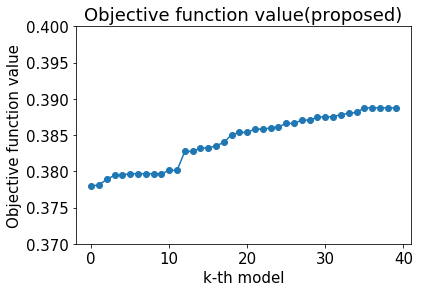

In [13]:
sort_func = sorted(scores)

index = np.arange(len(sort_func[:40]))
plt.plot(index, sort_func[:40], marker="o")
plt.ylim(0.37, 0.4)
plt.rcParams["font.size"] = 15
plt.title("Objective function value(proposed)")
plt.xlabel("k-th model")
plt.ylabel("Objective function value")

## Calculate Fairness(DP and EQ)

In [20]:
def calc_dp(X, model, sensitive_feature):
    pred = model.predict(X)
    dp_1 = 0
    dp_0 = 0
    for i in range(len(pred)):
        if pred[i] == 1:
            if sensitive_feature[i] == 1: dp_1 += 1
            else: dp_0 += 1
    return abs(dp_1 - dp_0)/len(X)

def calc_eq(X, y, model, sensitive_feature):
    pred = model.predict(X)
    dp_1 = 0
    dp_0 = 0
    for i in range(len(pred)):
        if (pred[i] == 1) and (y[i]==1):
            if sensitive_feature[i] == 1: dp_1 += 1
            else: dp_0 += 1
    return abs(dp_1 - dp_0)/len(X)

In [21]:
sen_feat_train = train.race.values
sen_feat_train

array([1, 1, 0, ..., 0, 0, 1])

In [37]:
dp_train_list = []
eq_train_list = []

rashomon = best_score + 0.15 * err_num
model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
for i in model_list:
    dp = calc_dp(X_train, i, sen_feat)
    eq = calc_eq(X_train, y_train, i, sen_feat)
    dp_train_list.append(dp)
    eq_train_list.append(eq)
    
print(dp_train_list)
print()
print(eq_train_list)

[0.33734011403914316, 0.39389736477115117, 0.4222530436122669, 0.4228694714131607, 0.01571890892279242, 0.021574973031283712, 0.028509785791339188, 0.024965325936199722, 0.024348898135305903, 0.06873169979966097, 0.04916011712128217, 0.0027739251040221915, 0.03975959315765141, 0.016951764524580058, 0.05671135768223147, 0.002003390352904916, 0.004160887656033287, 0.04499922946524888, 0.004160887656033287, 0.4188626907073509, 0.01880104792726152, 0.4106950223455078, 0.43581445523193096, 0.011403914316535676, 0.028355678841115735, 0.018030513176144243, 0.026352288488210817, 0.14763445831406996, 0.06426259824318077, 0.002311604253351826, 0.37925720449992295, 0.05732778548312529, 0.16720604099244876, 0.0007705347511172754, 0.002157497303128371, 0.021574973031283712, 0.46910155648019725, 0.024965325936199722, 0.38819540761288335, 0.02034211742949607, 0.005547850208044383, 0.002157497303128371, 0.021574973031283712, 0.4570812143627678, 0.028509785791339188, 0.01571890892279242, 0.067961165048

In [38]:
eps_list = []
num_model = []

dp_train_eps_list = []
eq_train_eps_list = []

for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
    eps_list.append(eps)
    num_model.append(len(model_list))
    
    dp_train_eps_list.append(dp_train_list[:len(model_list)])
    eq_train_eps_list.append(eq_train_list[:len(model_list)])
    
print(dp_train_eps_list[:3])
print(eq_train_eps_list[:3])

0
5
10
15
[[0.33734011403914316], [0.33734011403914316, 0.39389736477115117, 0.4222530436122669, 0.4228694714131607, 0.01571890892279242, 0.021574973031283712, 0.028509785791339188, 0.024965325936199722, 0.024348898135305903, 0.06873169979966097, 0.04916011712128217, 0.0027739251040221915, 0.03975959315765141, 0.016951764524580058, 0.05671135768223147, 0.002003390352904916, 0.004160887656033287, 0.04499922946524888, 0.004160887656033287, 0.4188626907073509, 0.01880104792726152, 0.4106950223455078, 0.43581445523193096, 0.011403914316535676, 0.028355678841115735, 0.018030513176144243, 0.026352288488210817, 0.14763445831406996, 0.06426259824318077, 0.002311604253351826, 0.37925720449992295], [0.33734011403914316, 0.39389736477115117, 0.4222530436122669, 0.4228694714131607, 0.01571890892279242, 0.021574973031283712, 0.028509785791339188, 0.024965325936199722, 0.024348898135305903, 0.06873169979966097, 0.04916011712128217, 0.0027739251040221915, 0.03975959315765141, 0.016951764524580058, 0.

In [66]:
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 20

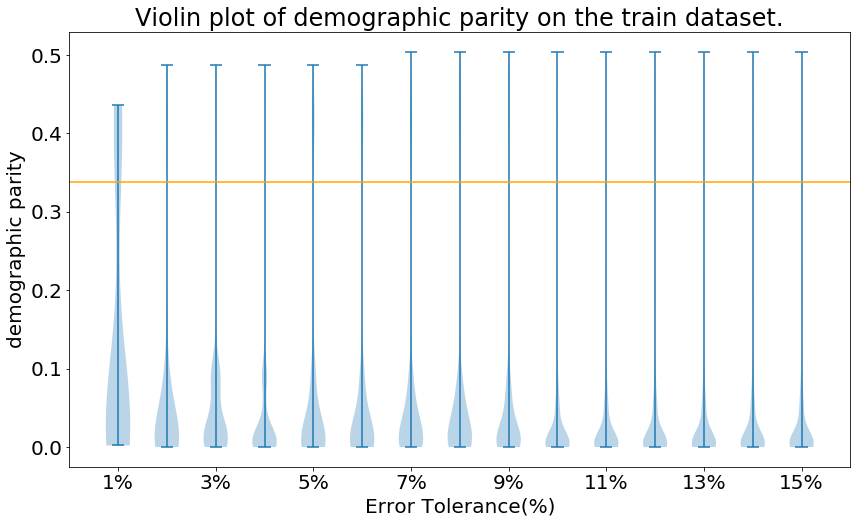

In [82]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.violinplot(dp_train_eps_list[1:])
plt.title("Violin plot of demographic parity on the train dataset.")
plt.xlabel("Error Tolerance(%)")
plt.ylabel("demographic parity")
plt.hlines(dp_train_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
plt.xlim(0, 16)
plt.show()

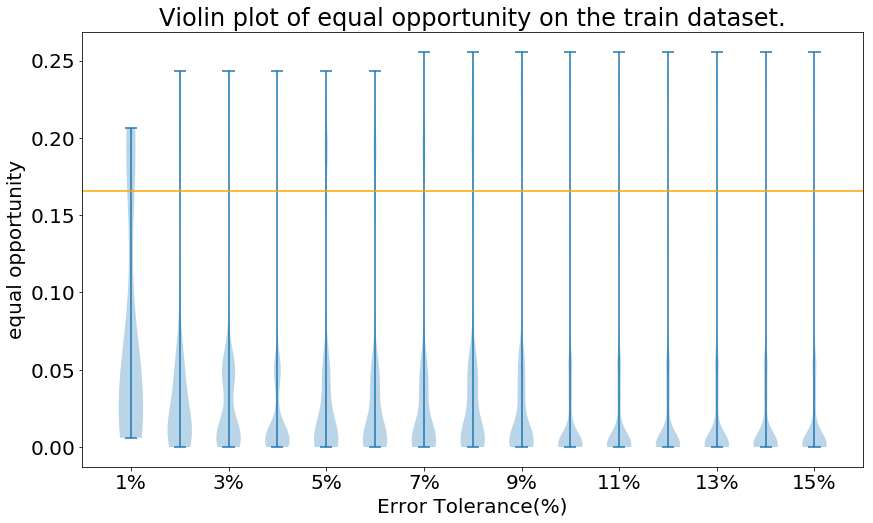

In [83]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.violinplot(eq_train_eps_list[1:])
plt.title("Violin plot of equal opportunity on the train dataset.")
plt.xlabel("Error Tolerance(%)")
plt.ylabel("equal opportunity")
plt.hlines(eq_train_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
plt.xlim(0, 16)
plt.show()

In [51]:
dp_test_list = []
eq_test_list = []
sen_feat_test = test.race.values

rashomon = best_score + 0.15 * err_num
model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
for i in model_list:
    dp = calc_dp(X_test, i, sen_feat_test)
    eq = calc_eq(X_test, y_test, i, sen_feat_test)
    dp_test_list.append(dp)
    eq_test_list.append(eq)
    
print(dp_test_list)
print()
print(eq_test_list)

[0.3231622746185853, 0.3883495145631068, 0.4160887656033287, 0.4119278779472954, 0.016643550624133148, 0.026352288488210817, 0.0319001386962552, 0.027739251040221916, 0.0319001386962552, 0.07073509015256588, 0.059639389736477116, 0.005547850208044383, 0.04854368932038835, 0.011095700416088766, 0.059639389736477116, 0.0027739251040221915, 0.004160887656033287, 0.05547850208044383, 0.004160887656033287, 0.4119278779472954, 0.022191400832177532, 0.39944521497919555, 0.42857142857142855, 0.015256588072122053, 0.0319001386962552, 0.016643550624133148, 0.027739251040221916, 0.1650485436893204, 0.07350901525658807, 0.005547850208044383, 0.37031900138696255, 0.05547850208044383, 0.17614424410540916, 0.008321775312066574, 0.008321775312066574, 0.026352288488210817, 0.47018030513176146, 0.027739251040221916, 0.37586685159500693, 0.004160887656033287, 0.004160887656033287, 0.0, 0.026352288488210817, 0.4521497919556172, 0.0319001386962552, 0.019417475728155338, 0.07628294036061026, 0.0499306518723

In [52]:
eps_list = []
num_model = []

dp_test_eps_list = []
eq_test_eps_list = []

for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
    eps_list.append(eps)
    num_model.append(len(model_list))
    
    dp_test_eps_list.append(dp_list[:len(model_list)])
    eq_test_eps_list.append(eq_list[:len(model_list)])
    
print(dp_test_eps_list[:3])
print(eq_test_eps_list[:3])

0
5
10
15
[[0.3231622746185853], [0.3231622746185853, 0.3883495145631068, 0.4160887656033287, 0.4119278779472954, 0.016643550624133148, 0.026352288488210817, 0.0319001386962552, 0.027739251040221916, 0.0319001386962552, 0.07073509015256588, 0.059639389736477116, 0.005547850208044383, 0.04854368932038835, 0.011095700416088766, 0.059639389736477116, 0.0027739251040221915, 0.004160887656033287, 0.05547850208044383, 0.004160887656033287, 0.4119278779472954, 0.022191400832177532, 0.39944521497919555, 0.42857142857142855, 0.015256588072122053, 0.0319001386962552, 0.016643550624133148, 0.027739251040221916, 0.1650485436893204, 0.07350901525658807, 0.005547850208044383, 0.37031900138696255], [0.3231622746185853, 0.3883495145631068, 0.4160887656033287, 0.4119278779472954, 0.016643550624133148, 0.026352288488210817, 0.0319001386962552, 0.027739251040221916, 0.0319001386962552, 0.07073509015256588, 0.059639389736477116, 0.005547850208044383, 0.04854368932038835, 0.011095700416088766, 0.0596393897

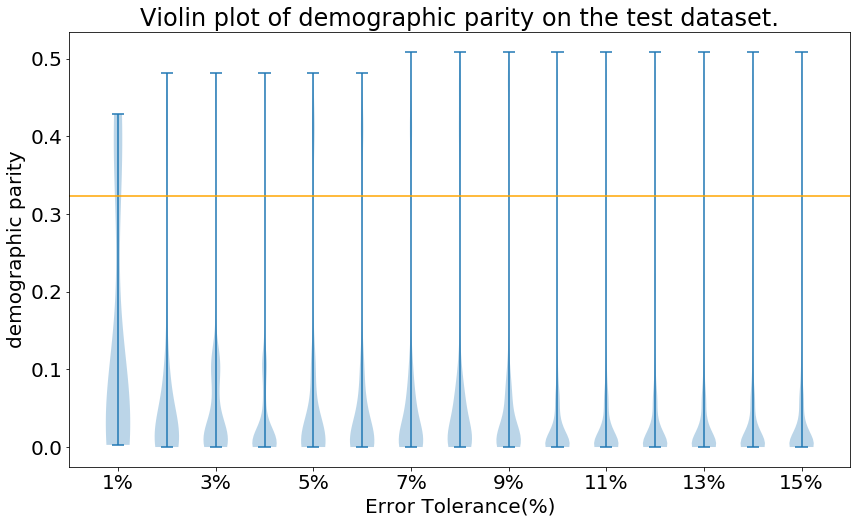

In [84]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.violinplot(dp_test_eps_list[1:])
plt.title("Violin plot of demographic parity on the test dataset.")
plt.xlabel("Error Tolerance(%)")
plt.ylabel("demographic parity")
plt.hlines(dp_test_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
plt.xlim(0, 16)
plt.show()

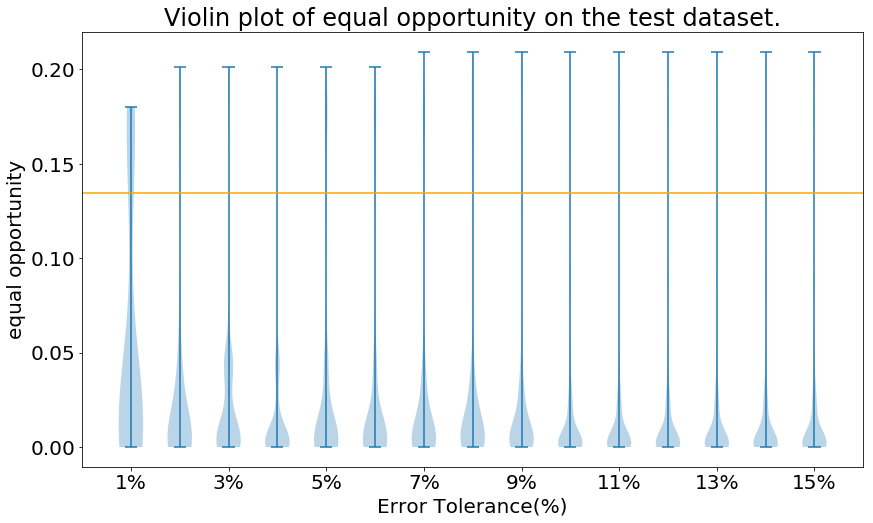

In [85]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.violinplot(eq_test_eps_list[1:])
plt.title("Violin plot of equal opportunity on the test dataset.")
plt.xlabel("Error Tolerance(%)")
plt.ylabel("equal opportunity")
plt.hlines(eq_test_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
plt.xlim(0, 16)
plt.show()

## Calculate Discrepancy and Ambiguity

In [15]:
def calc_discrepancy(X, model_list, model):
    d_list = []
    for i in range(len(model_list)):
        model_prime = model_list[i]
        d = 0
        for j in range(len(X)):
            if model.flow(X[j]) != model_prime.flow(X[j]): 
                #print(model.flow(X[j]))
                #print(model_prime.flow(X[j]))
                d += 1
            
        d_list.append(d)
    
    return max(d_list) / len(X)

def calc_ambiguity(X, model_list, model):
    ambiguity = 0
    best_pred = model.predict(X)
    for i in range(len(X)):
        for h in model_list:
            if model.flow(X[i]) != h.flow(X[i]):
                ambiguity += 1
                break
                
    return ambiguity / len(X)

In [17]:
# 0 ~ 0.15 まで　0.01刻みで
discre_list = []
amb_list = []
eps_list = []
num_model = []
for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in corels if row[1] <= rashomon]
    
    discrepancy = calc_discrepancy(X_train, model_list, best_model)
    discre_list.append(discrepancy)
    ambiguity = calc_ambiguity(X_train, model_list, best_model)
    amb_list.append(ambiguity)
    
    eps_list.append(i)
    num_model.append(len(model_list))

0
5
10
15


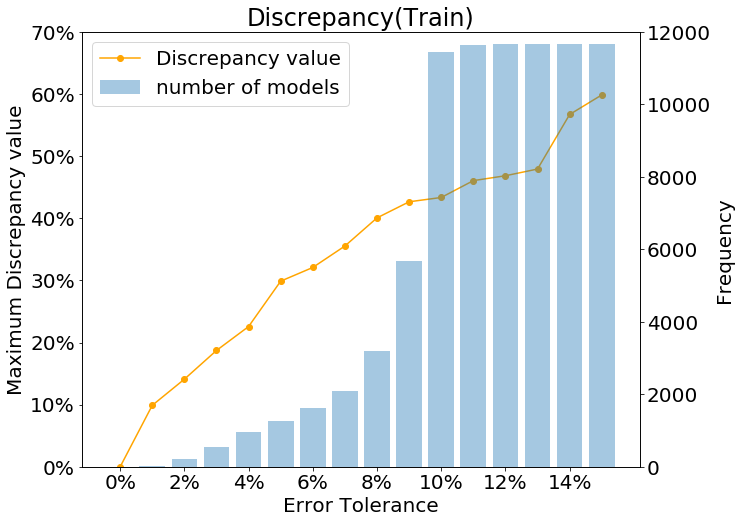

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
plt.rcParams["font.size"] = 20
plt.title("Discrepancy(Train)")
plt.xlabel("Error Tolerance")
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14], 
           ["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%"])
ax2 = ax1.twinx()
ax1.plot(eps_list, discre_list, color="orange", marker="o", label="Discrepancy value")
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 
ax1.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])
ax1.set_ylabel("Maximum Discrepancy value")
ax2.bar(eps_list, num_model, alpha=0.4, label="number of models")
ax2.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000]) 
ax2.set_ylabel("Frequency")
ax1.set_ylim(0, 0.7)
ax2.set_ylim(0,12000)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2,label1+label2, loc="upper left")

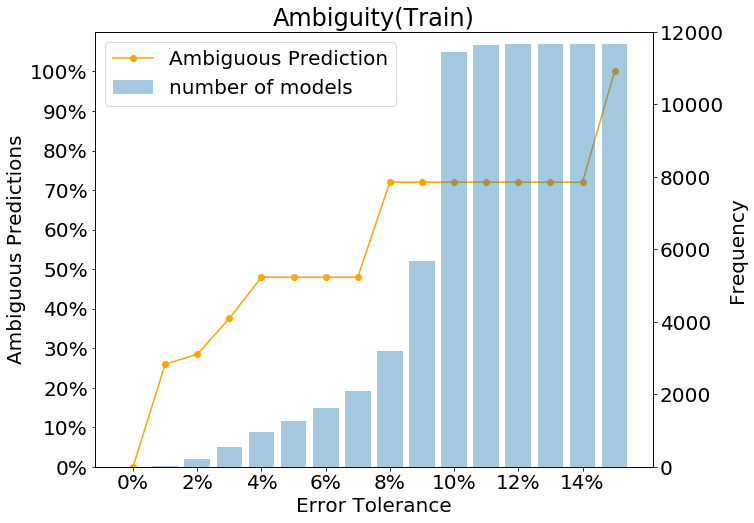

In [19]:
fig, ax3 = plt.subplots(1, 1, figsize=(10,8))
plt.rcParams["font.size"] = 20
#ax3 = fig.add_subplot(1, 2, 2)
plt.title("Ambiguity(Train)")
plt.xlabel("Error Tolerance")
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14], 
           ["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%"])
ax4 = ax3.twinx()
ax3.plot(eps_list, amb_list, color="orange", marker="o", label="Ambiguous Prediction")
ax3.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) 
ax3.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"])
ax3.set_ylabel("Ambiguous Predictions")
ax4.bar(eps_list, num_model, alpha=0.4, label="number of models")
ax4.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000]) 
ax4.set_ylabel("Frequency")
ax3.set_ylim(0, 1.1)
ax4.set_ylim(0,12000)
handler1, label1 = ax3.get_legend_handles_labels()
handler2, label2 = ax4.get_legend_handles_labels()
ax3.legend(handler1+handler2,label1+label2, loc="upper left")

In [22]:
# 0 ~ 0.15 まで　0.01刻みで
discre_list = []
amb_list = []
eps_list = []
num_model = []
for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in corels if row[1] <= rashomon]
    
    discrepancy = calc_discrepancy(X_test, model_list, best_model)
    discre_list.append(discrepancy)
    ambiguity = calc_ambiguity(X_test, model_list, best_model)
    amb_list.append(ambiguity)
    
    eps_list.append(i)
    num_model.append(len(model_list))

0
5
10
15


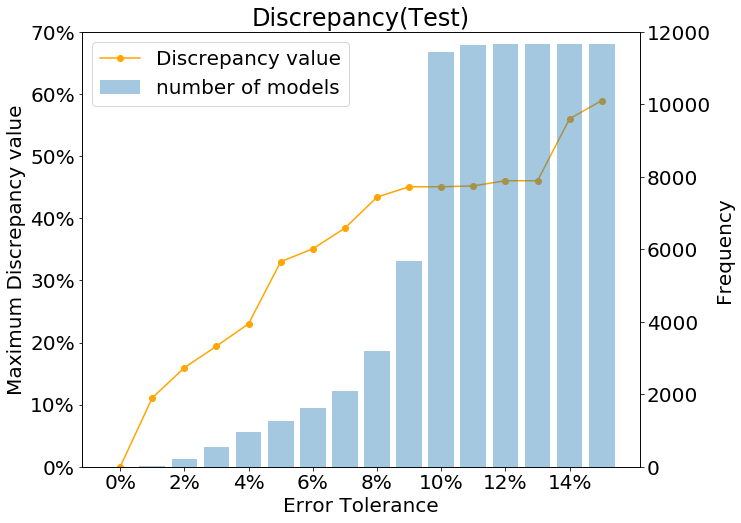

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,8))
plt.rcParams["font.size"] = 20
plt.title("Discrepancy(Test)")
plt.xlabel("Error Tolerance")
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14], 
           ["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%"])
ax2 = ax1.twinx()
ax1.plot(eps_list, discre_list, color="orange", marker="o", label="Discrepancy value")
ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 
ax1.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])
ax1.set_ylabel("Maximum Discrepancy value")
ax2.bar(eps_list, num_model, alpha=0.4, label="number of models")
ax2.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000]) 
ax2.set_ylabel("Frequency")
ax1.set_ylim(0, 0.7)
ax2.set_ylim(0,12000)
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1+handler2,label1+label2, loc="upper left")

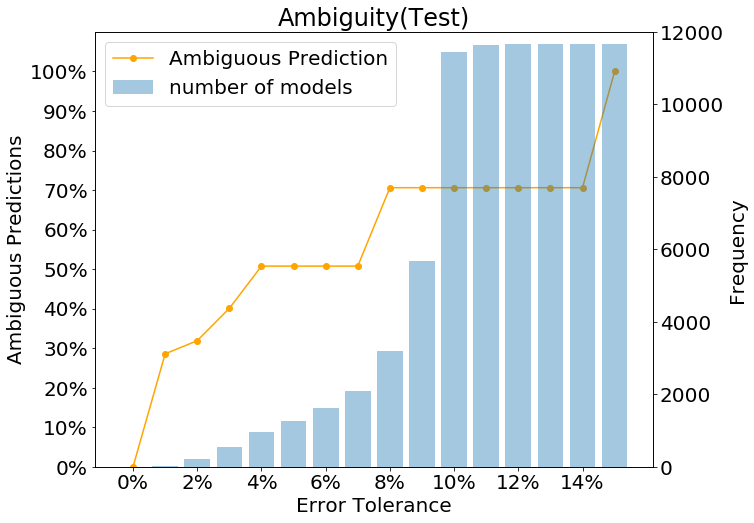

In [24]:
fig, ax3 = plt.subplots(1, 1, figsize=(10,8))
plt.rcParams["font.size"] = 20
#ax3 = fig.add_subplot(1, 2, 2)
plt.title("Ambiguity(Test)")
plt.xlabel("Error Tolerance")
plt.xticks([0, 2, 4, 6, 8, 10, 12, 14], 
           ["0%", "2%", "4%", "6%", "8%", "10%", "12%", "14%"])
ax4 = ax3.twinx()
ax3.plot(eps_list, amb_list, color="orange", marker="o", label="Ambiguous Prediction")
ax3.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) 
ax3.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"])
ax3.set_ylabel("Ambiguous Predictions")
ax4.bar(eps_list, num_model, alpha=0.4, label="number of models")
ax4.set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000]) 
ax4.set_ylabel("Frequency")
ax3.set_ylim(0, 1.1)
ax4.set_ylim(0,12000)
handler1, label1 = ax3.get_legend_handles_labels()
handler2, label2 = ax4.get_legend_handles_labels()
ax3.legend(handler1+handler2,label1+label2, loc="upper left")